In [1]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from loess import loess_1d

import sys
sys.path.insert(0,'..')
from BMR.ml_models import *

plt.rcParams['figure.figsize'] = [8, 6]

# set seed
random.seed(1234)

In [42]:
max_x = max_y = 6.0

def fun_Himmelblau_unscaled(x):
    y = (x[:, 0]**2 + x[:, 1] - 11)**2 + (x[:, 0] + x[:, 1]**2 - 7)**2
    return y.reshape(-1,1)

max_val = np.max(fun_Himmelblau_unscaled(np.array([[max_x, max_x], [max_x, -max_x], [-max_x, max_x], [-max_x, -max_x]])))

def fun_Himmelblau(x):
    return fun_Himmelblau_unscaled(x)/max_val

def generate_Himmelblau(n=100, sigma=0):
    x = (ss.uniform.rvs(size=(n, 2))-0.5)*max_x*2
    y = fun_Himmelblau(x)
    if sigma>0:
        norm = ss.norm(loc=0, scale=sigma)
        y += norm.rvs(size=(n, 1))
    y = np.ravel(y)
    return x, y

In [6]:
n = 250
sigma = 0.01
X, y = generate_Himmelblau(n=n, sigma=sigma)

In [ ]:
rf_params = get_rf_params(X, y)

In [ ]:
bmr_params_1 = get_bmr_params(X, y, M=25, degree=1)

In [68]:
def get_bias_variance(method, params, x_pred):
    y_true = fun_Himmelblau(x_pred)
    preds = []
    for loop in range(50):
        X, y = generate_Himmelblau(n=250, sigma=0.01)
        model = method(**params)
        model.fit(X, y)
        pred = model.predict(x_pred)
        preds.append(pred)
    bias = [p.reshape(-1, 1) -y_true for p in preds]
    var = [(p.reshape(-1, 1) - y_true)**2 for p in preds]
    bias = np.array(bias)[:, :, 0]
    var = np.array(var)[:, :, 0]
    mse = bias**2 + var
    return bias, var, mse

In [69]:
x_pred = np.array([[0, 0], [1, 1], [1, -1], [-1, 1], [-1, -1], [4,4], [0, 4], [4, 0]])

In [70]:
rf_bias, rf_mse = get_rf_bias_variance(rf_params, x_pred)

In [75]:
np.mean(np.abs(rf_bias), axis=0)

array([0.00571771, 0.00642787, 0.00499176, 0.00644402, 0.00497159,
       0.04020167, 0.00703376, 0.00421864])

In [77]:
np.mean(rf_mse, axis=0)

array([5.78432187e-05, 6.04907108e-05, 3.86264343e-05, 5.81844809e-05,
       3.68654959e-05, 1.95601838e-03, 7.15127937e-05, 2.69640631e-05])

In [3]:
def fit_models(x, y, x_pred, alphas, epsilons):
    # Linear Model
    lm = LinearRegression().fit(X=x, y=y)
    y_lm = lm.predict(x_pred)[0][0]
    # Lasso
    y_lasso = []
    for alpha in alphas:
        lasso = Lasso(alpha=alpha).fit(X=x, y=y)
        y_lasso.append(lasso.predict(x_pred)[0])
    # BMR
    y_bmr = []
    for epsilon in epsilons:
        bmr = BMR(min_n_pts=10, M=20, substitution_policy='nearest', degree=1, epsilon=epsilon)
        bmr.fit(x=x, y=y)
        y_bmr.append(bmr.predict(x_pred)[0])
    
    return y_lm, y_lasso, y_bmr

In [4]:
def compute_bias_variance(model_function, x_pred, loops=50, n=100, plot=True, title=''):
    epsilons=[0.1, 0.2, 0.3, 0.5, 0.75, 1, 1.5, 2.0, 3.0, 10]
    x_pred = np.array([[x_pred]])
    ytrue = model_function(x_pred)
    ys = []
    for loop in range(loops):
        if loop % 10 == 0:
            print(f'{title} Loop: {loop}')
        x, y = sim_data(model_function=model_function, n=n)
        y_lm, y_lasso, y_bmr = fit_models(x, y, x_pred, alphas=[0.01, 0.1, 1, 10], epsilons=epsilons)
        ys.append([y_lm, *y_lasso, *y_bmr])
    ys = np.array(ys)-ytrue
    
    bias = np.mean(ys, axis=0)
    var = np.var(ys, axis=0)
    mse = bias**2 + var
    
    if plot:
        # plot LM
        plt.axhline(y=bias[0], color='blue', linestyle='-', label='LinearRegression Bias')
        plt.axhline(y=var[0], color='blue', linestyle=':', label='LinearRegression Var')
        plt.axhline(y=mse[0], color='green', linestyle='-', label='LinearRegression MSE')
        # plot BMR
        plt.plot(epsilons, bias[-len(epsilons):], '-', label='BMR Bias', color='black')
        plt.plot(epsilons, var[-len(epsilons):], 'o:', label='BMR Var', color='black')
        plt.plot(epsilons, mse[-len(epsilons):], '-', label='BMR MSE', color='red')
        # plot LASSO
        plt.axhline(y=bias[2], color='orange', linestyle='-', label='Lasso(lambda=0.1) Bias')
        plt.axhline(y=var[2], color='orange', linestyle=':',  label='Lasso(lambda=0.1) Var')
        plt.axhline(y=mse[2], color='gray', linestyle='-', label='Lasso(lambda=0.1) MSE')
        
        plt.legend()
        plt.xlim((0,3))
        plt.xlabel('espilon')
        plt.title(title + f', x*={x_pred[0][0]}')
        plt.show()
    
    return bias, var, mse

y = 2+3x+N(0,3) Loop: 0
y = 2+3x+N(0,3) Loop: 10
y = 2+3x+N(0,3) Loop: 20
y = 2+3x+N(0,3) Loop: 30
y = 2+3x+N(0,3) Loop: 40


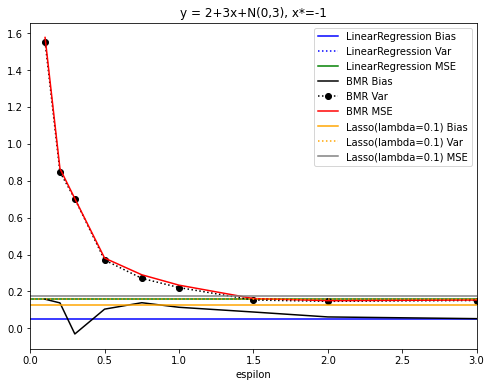

y = 2+3x+N(0,3) Loop: 0
y = 2+3x+N(0,3) Loop: 10
y = 2+3x+N(0,3) Loop: 20
y = 2+3x+N(0,3) Loop: 30
y = 2+3x+N(0,3) Loop: 40


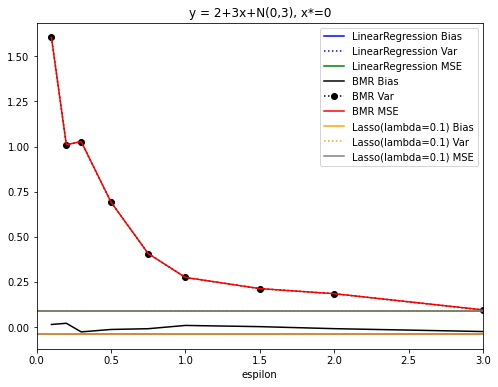

y = 2+3x+N(0,3) Loop: 0
y = 2+3x+N(0,3) Loop: 10
y = 2+3x+N(0,3) Loop: 20
y = 2+3x+N(0,3) Loop: 30
y = 2+3x+N(0,3) Loop: 40


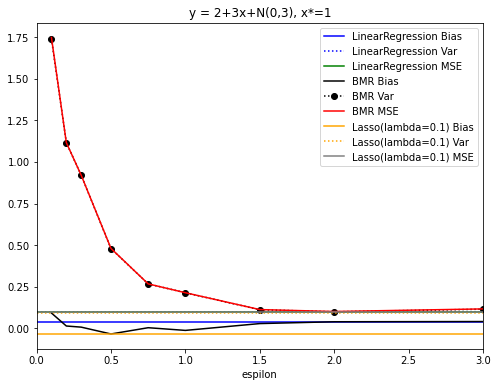

In [5]:
loops=50
bias, var, mse = compute_bias_variance(model_function=model_linear, x_pred=-1, loops=loops, n=100, title=f'y = 2+3x+N(0,3)')
bias, var, mse = compute_bias_variance(model_function=model_linear, x_pred=0, loops=loops, n=100, title=f'y = 2+3x+N(0,3)')
bias, var, mse = compute_bias_variance(model_function=model_linear, x_pred=1, loops=loops, n=100, title=f'y = 2+3x+N(0,3)')

y = 3+2x^2+N(0,3) Loop: 0
y = 3+2x^2+N(0,3) Loop: 10
y = 3+2x^2+N(0,3) Loop: 20
y = 3+2x^2+N(0,3) Loop: 30
y = 3+2x^2+N(0,3) Loop: 40


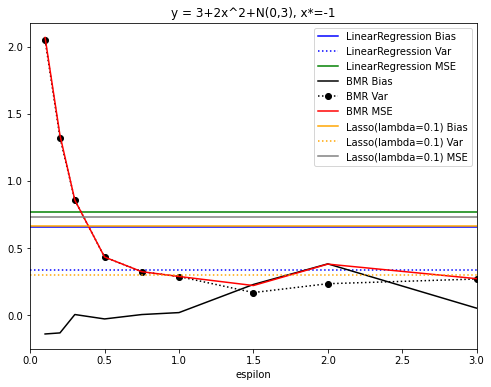

y = 3+2x^2+N(0,3) Loop: 0
y = 3+2x^2+N(0,3) Loop: 10
y = 3+2x^2+N(0,3) Loop: 20
y = 3+2x^2+N(0,3) Loop: 30
y = 3+2x^2+N(0,3) Loop: 40


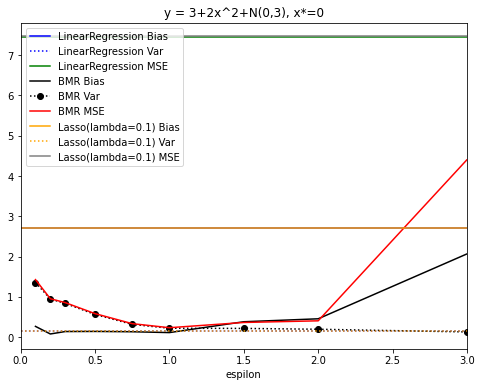

y = 3+2x^2+N(0,3) Loop: 0
y = 3+2x^2+N(0,3) Loop: 10
y = 3+2x^2+N(0,3) Loop: 20
y = 3+2x^2+N(0,3) Loop: 30
y = 3+2x^2+N(0,3) Loop: 40


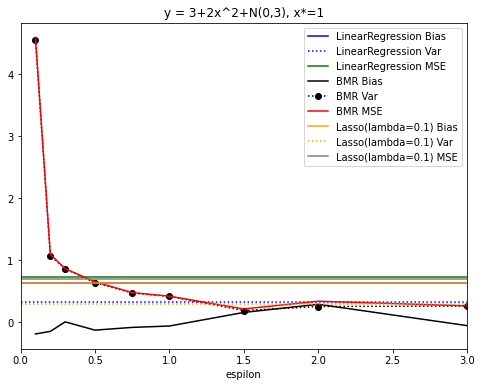

In [6]:
loops=50
bias, var, mse = compute_bias_variance(model_function=model_quadratic, x_pred=-1, loops=loops, n=100, title=f'y = 3+2x^2+N(0,3)')
bias, var, mse = compute_bias_variance(model_function=model_quadratic, x_pred=0, loops=loops, n=100, title=f'y = 3+2x^2+N(0,3)')
bias, var, mse = compute_bias_variance(model_function=model_quadratic, x_pred=1, loops=loops, n=100, title=f'y = 3+2x^2+N(0,3)')